# Transformer Implementation from Scratch in PyTorch

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

import os
import random
import numpy as np
import pandas as pd
import math

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['axes.grid'] = True

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'USING DEVICE: {device}')

USING DEVICE: cuda


# Hyperparameters

In [2]:
hyperparameters = {
    'lags': 35,
    'forecast': 1,
    'input_features_size': 16,
    'hidden_features_size': 256,
    'output_features_size': 16,
    'num_heads': 16,
    'ff_dim': 256*4, # usually 4 times the hidden feature size
    'num_decoder_layers': 4,
    'emb_dropout_prob': 0.1,
    'attn_dropout_prob': 0.1,
    'ff_dropout_prob': 0.1,
    'attn_use_bias': False,
    'ff_use_bias': False,
    'output_features_bias': False,
    'batch_size': 32,
    'split_ratio': 0.8, # 80% training, 20% testing
    'learning_rate': 0.001,
    'num_epochs': 150,
}

hyperparameters['window_size'] =  hyperparameters['lags'] + hyperparameters['forecast']

# Dataset

In [3]:
# Airline Passgeners
#df_full = pd.read_csv('data/airline_passengers/airline-passengers.csv')

# Panama Electricity Load Forecasting
df_full = pd.read_csv('data/panama_electricity_load_forecasting/train.csv')

df_full.head()

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,03-01-2015 01:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
1,03-01-2015 02:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2,03-01-2015 03:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
3,03-01-2015 04:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
4,03-01-2015 05:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0


In [4]:
# Airline Passgeners
#df_full['Month'] = pd.to_datetime(df_full['Month'])

# Panama Electricity Load Forecasting
df_full['datetime'] = pd.to_datetime(df_full['datetime'], dayfirst=True)

df_full.head()

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
1,2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2,2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
3,2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
4,2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0


In [5]:
# # Airline Passgeners
#df_full.set_index('Month', inplace=True)

# Panama Electricity Load Forecasting
df_full.set_index('datetime', inplace=True)

df_full.tail()

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
datetime,,,,,,,,,,,,,,,,
2019-12-31 19:00:00,1301.6065,26.635645,0.018421,0.013165,13.184052,25.135645,0.018048,0.064240,3.086798,23.620020,0.016697,0.073425,3.865351,22,1,0
2019-12-31 20:00:00,1250.9634,26.495935,0.018162,0.014713,13.443892,24.769373,0.017781,0.058838,3.659980,23.284998,0.016606,0.064362,4.171572,22,1,0
2019-12-31 21:00:00,1193.6802,26.354456,0.017980,0.013836,13.442195,24.479456,0.017606,0.038086,3.769294,23.041956,0.016492,0.054260,4.045283,22,1,0
2019-12-31 22:00:00,1130.4575,26.166895,0.017965,0.018486,13.420656,24.112207,0.017393,0.020386,3.872397,22.862207,0.016401,0.055557,3.843736,22,1,0
2019-12-31 23:00:00,1084.4737,25.976373,0.018072,0.023315,13.749788,23.663873,0.017156,0.019531,4.165276,22.726373,0.016302,0.061371,3.793209,22,1,0


<Axes: xlabel='datetime'>

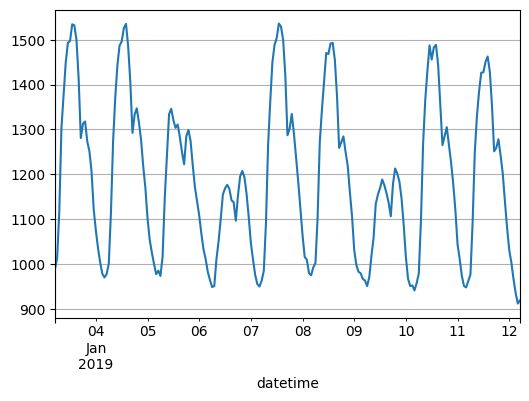

In [6]:
# Airline Passgeners
#df_full.plot()

# Panama Electricity Load Forecasting
df_full.loc['2019-01-03 05:00:00':'2019-01-12 05:00:00', 'nat_demand'].plot()

# Standart Scaler
* Exercise: Try without scaler, see if learning works!

<Axes: xlabel='datetime'>

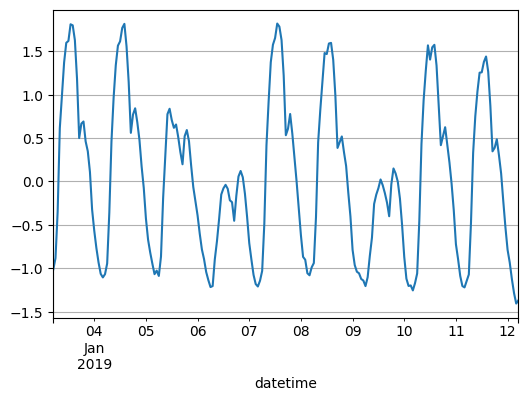

In [7]:
scaler = StandardScaler()

# Airline Passgeners
#df_full['Passengers'] = scaler.fit_transform(df_full['Passengers'].values.reshape(-1, 1))

# Panama Electricity Load Forecasting
df_full['nat_demand'] = scaler.fit_transform(df_full['nat_demand'].values.reshape(-1, 1))

# Airline Passgeners
#df_full.plot()

# Panama Electricity Load Forecasting
df_full.loc['2019-01-03 05:00:00':'2019-01-12 05:00:00', 'nat_demand'].plot()

### Time series data shape: 
Unbatched: $(S, F)$

* $S:$ Sequence Length
* $F:$ Number of Features

Batched: $(B, S, F)$
* $B:$ Batch Size

In [8]:
df_full.shape

(43775, 16)

# Model
## Date2Vec

In [9]:
# TODO

## Transformer Decoder (GPT)

In [10]:
# subsequent_mask
# lower triangular mask matrix
# (1 -> normal token, 0 -> mask token)
# pad_mask should be float tensor
# if not -> subsequent_mask * torch.tensor(enc.attention_mask)
# pad_mask enc.attention_mask (from tokenizer)
# both masks are in form: 1 -> normal token, 0 -> mask token


class MultiHeadAttention(nn.Module):
    def __init__(self, features_dim, num_heads, use_bias, use_lookahead_mask=False):
        super().__init__()
        self.features_dim = features_dim
        self.num_heads = num_heads
        self.head_dim = features_dim // num_heads
        self.use_lookahead_mask = use_lookahead_mask
        
        assert self.head_dim * num_heads == features_dim, 'Cannot divide into heads equally!'

        self.query = nn.Linear(features_dim, features_dim, bias=use_bias)
        self.key = nn.Linear(features_dim, features_dim, bias=use_bias)
        self.value = nn.Linear(features_dim, features_dim, bias=use_bias)
        self.out = nn.Linear(features_dim, features_dim, bias=use_bias)
        
    def forward(self, query, key, value, pad_mask=None):
        # query: (batch_size, seq_len_q, features_dim)
        # key:   (batch_size, seq_len_k, features_dim)
        # value: (batch_size, seq_len_v, features_dim)
        
        batch_size, seq_len_q, _ = query.size()
        _, seq_len_k, _ = key.size()
        
        Q = self.query(query)
        K = self.key(key)
        V = self.value(value)

        # DIVIDE INTO ATTENTION HEADS
        # (batch_size, seq_len, features_dim) -> (batch_size, seq_len_q/k/v, num_heads, head_dim)
        Q = Q.view(batch_size, -1, self.num_heads, self.head_dim)
        K = K.view(batch_size, -1, self.num_heads, self.head_dim)
        V = V.view(batch_size, -1, self.num_heads, self.head_dim)

        # Switch seq_len and num_heads dim (group sequences into heads)
        # (batch_size, seq_len_q/k/v, num_heads, head_dim) -> (batch_size, num_heads, seq_len_q/k/v, head_dim)
        Q = Q.transpose(1, 2)
        K = K.transpose(1, 2)
        V = V.transpose(1, 2)

        # SCALED DOT PRODUCT ATTENTION
        # (batch_size, num_heads, seq_len_q, head_dim) X (batch_size, num_heads, head_dim, seq_len_k)
        scores = torch.matmul(Q, K.transpose(2, 3))
        scores = scores / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))
        
        # Lookahead mask (used in Decoder)
        if self.use_lookahead_mask:
            subsequent_mask = torch.tril(torch.ones(seq_len_q, seq_len_k)).to(query.device)
            scores.masked_fill_(subsequent_mask == 0, 1e-10)

        # Padding mask
        if pad_mask is not None:
            __pad_mask = pad_mask.unsqueeze(1).unsqueeze(3)
            # __pad_mask.shape: (batch_size, 1, seq_len_q, 1)
            # pad mask is broadcasted from q dimension 
            # enc/dec case: q is the dimension of decoder output, k and v are from encoder
            # NOTE: using float('-inf') here can cause numerical instability!
            scores.masked_fill_(__pad_mask == 0, 1e-10)

        # ATTTENTION MATRIX (batch_size, num_heads, seq_len_q, seq_len_k)
        attention = torch.softmax(scores, dim=-1)
        # NOTE: seq_len_k and seq_len_v assumed to be the same
        # (batch_size, num_heads, seq_len_q, seq_len_k) X (batch_size, num_heads, seq_len_v, head_dim)
        # out: (batch_size, num_heads, seq_len_q, head_dim)
        out = torch.matmul(attention, V)

        # (batch_size, num_heads, seq_len_q, head_dim) -> (batch_size, seq_len_q, num_heads, head_dim)
        out = out.transpose(1, 2).contiguous()
        # CONCAT ATTENTION HEADS
        # (batch_size, seq_len_q, num_heads, head_dim) -> (batch_size, seq_len_q, features_dim)
        # num_heads * head_dim = features_dim
        out = out.view(batch_size, -1, self.features_dim)
        out = self.out(out)
        # final out: (batch_size, seq_len_q, features_dim)
        return out


class FeedForward(nn.Module):
    def __init__(self, features_dim, ff_dim, use_bias):
        super().__init__()
        
        self.ff_block = nn.Sequential(
            nn.Linear(features_dim, ff_dim, bias=use_bias),
            nn.GELU(),
            nn.Linear(ff_dim, features_dim, bias=use_bias),
        )
        
    def forward(self, x):
        return self.ff_block(x)


class AttentionResidualConnection(nn.Module):
    """
    Multihead Attention
    Residual Connection with Pre-Layernorm + Dropout
    """
    def __init__(self, layer, features_dim, dropout_prob):
        super().__init__()
        self.layer = layer
        self.norm = nn.LayerNorm(features_dim)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, q, k, v, mask):
        return q + self.dropout(self.layer(self.norm(q), self.norm(k), self.norm(v), mask))


class FeedForwardResidualConnection(nn.Module):
    """
    Feedforward Connection
    Residual Connection with Pre-Layernorm + Dropout
    """
    def __init__(self, layer, features_dim, dropout_prob):
        super().__init__()
        self.layer = layer
        self.norm = nn.LayerNorm(features_dim)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        return x + self.dropout(self.layer(self.norm(x)))

## Transformer Model

In [11]:
class MaskedOnlyDecoderLayer(nn.Module):
    """
    Used for GPT
    """
    def __init__(
        self, 
        features_dim, 
        num_heads, 
        ff_dim, 
        attn_dropout_prob,
        ff_dropout_prob,
        attn_use_bias,
        ff_use_bias
    ):
        super().__init__()
        
        self.masked_mha = AttentionResidualConnection(
            layer=MultiHeadAttention(features_dim, num_heads, attn_use_bias, use_lookahead_mask=True), 
            features_dim=features_dim, 
            dropout_prob=attn_dropout_prob,
        )

        self.ff = FeedForwardResidualConnection(
            layer=FeedForward(features_dim, ff_dim, ff_use_bias), 
            features_dim=features_dim, 
            dropout_prob=ff_dropout_prob,
        )
        
    def forward(self, x_input, pad_mask):
        masked_mha_out = self.masked_mha(x_input, x_input, x_input, pad_mask)
        ff_out = self.ff(masked_mha_out)
        return ff_out


class GPTTimeSeries(nn.Module):
    def __init__(
        self, 
        #vocab_size, 
        input_features_size,
        features_dim, 
        output_features_size,
        forecast_size,
        num_heads, 
        ff_dim, 
        num_decoder_layers,
        emb_dropout_prob,
        attn_dropout_prob,
        ff_dropout_prob,
        attn_use_bias,
        ff_use_bias,
        #vocab_projection_bias,
        output_features_bias,
    ):
        super().__init__()
        self.features_dim = features_dim
        self.forecast_size = forecast_size

        #self.token_emb = nn.Embedding(vocab_size, features_dim)
        self.input_projection = nn.Linear(input_features_size, features_dim)
        
        # Learnable position embbedings
        #self.position_emb = nn.Embedding(max_seq_len, features_dim)

        self.emb_dropout_prob = nn.Dropout(p=emb_dropout_prob)
        
        # NOTE: nn.Sequential can't handle multiple inputs!
        self.dec_layers = nn.ModuleList(
            [MaskedOnlyDecoderLayer(
                features_dim, 
                num_heads, 
                ff_dim, 
                attn_dropout_prob, 
                ff_dropout_prob,
                attn_use_bias,
                ff_use_bias
            ) for _ in range(num_decoder_layers)]
        )
        
        self.layernorm_final = nn.LayerNorm(features_dim)

        #self.vocab_projection = nn.Linear(features_dim, vocab_size, bias=vocab_projection_bias)
        self.output_projection = nn.Linear(features_dim, output_features_size, bias=output_features_bias)
        
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def generate_positional_embbedings(self, seq_len):
        pe = torch.zeros(seq_len, self.features_dim)
        position = torch.arange(0, seq_len).unsqueeze(1)
        
        div_term = torch.exp(
            torch.arange(0, self.features_dim, 2) * -(math.log(10000.0) / self.features_dim)
        )
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        return pe.unsqueeze(0)
 
    def forward(self, x_input, pad_mask=None):
        _batch_size, _seq_len, _ = x_input.size()

        #_token_emb = self.token_emb(x_input)
        _token_emb = self.input_projection(x_input)
        
        _position_emb = self.generate_positional_embbedings(_seq_len).to(x_input.device)
        x_input = self.emb_dropout_prob(_token_emb + _position_emb)
        
        # Self attenting Masked MHA
        for _dec_layer in self.dec_layers:
            x_input = _dec_layer(x_input, pad_mask)
        
        x_input = self.layernorm_final(x_input)

        # Slice forecast
        x_input = x_input[:, -self.forecast_size:, :]
        
        # Convert output features
        #x_input = self.vocab_projection(x_input)
        x_input = self.output_projection(x_input)        
        
        return x_input

### Initialized Model with Hyperparameters

In [12]:
model = GPTTimeSeries(
    input_features_size=hyperparameters['input_features_size'],
    features_dim=hyperparameters['hidden_features_size'],
    output_features_size=hyperparameters['output_features_size'],
    forecast_size=hyperparameters['forecast'],
    num_heads=hyperparameters['num_heads'],
    ff_dim=hyperparameters['ff_dim'],
    num_decoder_layers=hyperparameters['num_decoder_layers'],
    emb_dropout_prob=hyperparameters['emb_dropout_prob'],
    attn_dropout_prob=hyperparameters['attn_dropout_prob'],
    ff_dropout_prob=hyperparameters['ff_dropout_prob'],
    attn_use_bias=hyperparameters['attn_use_bias'],
    ff_use_bias=hyperparameters['ff_use_bias'],
    output_features_bias=hyperparameters['output_features_bias'],
)

### Number of parameters

In [13]:
def print_model_parameters(model):
    print(f'{sum(p.numel() for p in model.parameters()):,}')

In [14]:
print('Number of parameters:')
print_model_parameters(model)

Number of parameters:
3,158,784


In [15]:
dummy_data = torch.randn(hyperparameters['batch_size'], hyperparameters['window_size'], hyperparameters['input_features_size'])
            
o = model(dummy_data)
o.shape

torch.Size([32, 1, 16])

# Sliding Window 
*  **NOTE: "hyperparameters['lags'] + hyperparameters['forecast'] = hyperparameters['window_size']" MUST HOLD**

### Slide Methods

In [16]:
dummy_data = list(range(100))

# increase by 1
single_step = range(0, len(dummy_data)-hyperparameters['window_size']+1, 1)
# increase by hyperparameters['window_size']
window_step = range(0, len(dummy_data)-hyperparameters['window_size']+1, hyperparameters['window_size'])


#for start_index in single_step:
for start_index in window_step:
    print(f"Start: {start_index}, End: {start_index+hyperparameters['window_size']}")

    # Slice window from data 
    data_window = dummy_data[start_index:start_index+hyperparameters['window_size']]

    # Split current window into lags and forecast
    data_lag = data_window[:hyperparameters['lags']]
    data_forecast = data_window[-hyperparameters['forecast']:]

    print(f'Lag: {data_lag}, forecast: {data_forecast}')

Start: 0, End: 36
Lag: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34], forecast: [35]
Start: 36, End: 72
Lag: [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70], forecast: [71]


# Dataset

In [17]:
class TimeSeriesDataset(Dataset):
    def __init__(self, df, lags, forecast):
        self.df = df
        self.lags = lags
        self.forecast = forecast
        self.window_size = lags + forecast
        
    def __len__(self):
        number_of_samples = self.df.shape[0]
        # make sure that last window fits
        return number_of_samples - self.window_size

    def __getitem__(self, start_idx):

        # get a NumPy array of size: (hyperparameters['window_size'], NUM_FEATURES)
        sample_window = self.df.iloc[start_idx:start_idx+self.window_size].values

        # divide window into lags and forecast:
        # (hyperparameters['lags'], NUM_FEATURES)
        lags = sample_window[:self.lags, :]
        # (hyperparameters['forecast'], NUM_FEATURES)
        forecast = sample_window[-self.forecast:, :]

        # convert to tensor
        lags = torch.tensor(lags, dtype=torch.float32)
        forecast = torch.tensor(forecast, dtype=torch.float32)
        return lags, forecast

In [18]:
dataset_full = TimeSeriesDataset(
    df_full,
    hyperparameters['lags'],
    hyperparameters['forecast'],
)

In [19]:
_lags, _forecast = dataset_full[0]
_lags.shape, _forecast.shape

(torch.Size([35, 16]), torch.Size([1, 16]))

### Train/Test Split

In [20]:
train_size = int(hyperparameters['split_ratio'] * len(dataset_full))
test_size = len(dataset_full) - train_size

train_size, test_size

(34991, 8748)

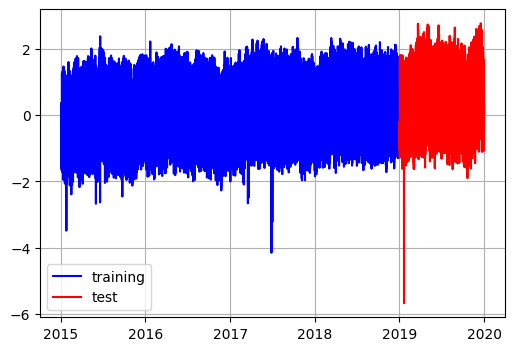

In [21]:
df_train = df_full.iloc[:train_size, :]
df_test = df_full.iloc[-test_size:, :]

# Airline Passgeners
#plt.plot(df_train.index, df_train['Passengers'], c='blue', label='training')
#plt.plot(df_test.index, df_test['Passengers'], c='red', label='test')

# Panama Electricity Load Forecasting
plt.plot(df_train.index, df_train['nat_demand'], c='blue', label='training')
plt.plot(df_test.index, df_test['nat_demand'], c='red', label='test')

plt.legend()

In [22]:
dataset_train = TimeSeriesDataset(
    df_train,
    hyperparameters['lags'],
    hyperparameters['forecast'],
)

dataset_test = TimeSeriesDataset(
    df_test,
    hyperparameters['lags'],
    hyperparameters['forecast'],
)

# Dataloader

In [23]:
dataloader_full = DataLoader(
    dataset_full,
    batch_size=hyperparameters['batch_size'],
    shuffle=False,
)

dataloader_train = DataLoader(
    dataset_train,
    batch_size=hyperparameters['batch_size'],
    shuffle=False,
)

dataloader_test = DataLoader(
    dataset_test,
    batch_size=hyperparameters['batch_size'],
    shuffle=False,
)

print(f'Number of batches (total): {len(dataloader_full)}')
print(f'Number of batches (train): {len(dataloader_train)}')
print(f'Number of batches (test): {len(dataloader_test)}')

Number of batches (total): 1367
Number of batches (train): 1093
Number of batches (test): 273


In [24]:
_lags_batch, _forecast_batch = next(iter(dataloader_full))
# (hyperparameters['batch_size'], hyperparameters['lags'], NUM_FEATURES), # (hyperparameters['batch_size'], hyperparameters['forecast'], NUM_FEATURES)
_lags_batch.shape, _forecast_batch.shape

(torch.Size([32, 35, 16]), torch.Size([32, 1, 16]))

In [25]:
len(dataloader_full)

1367

# Training

### Training Functions

In [26]:
def train_iter(model, dataloader, optimizer, criterion, device):
    model.train()

    avg_loss = []
    
    for (lags, forecast) in dataloader:

        lags = lags.to(device)
        forecast = forecast.to(device)
        
        optimizer.zero_grad()
    
        forecast_pred = model(lags)
        
        loss = criterion(forecast_pred, forecast)
        
        loss.backward()
        optimizer.step()

        avg_loss.append(loss.item())

    return sum(avg_loss) / len(avg_loss)


@torch.no_grad()
def eval_iter(model, dataloader, criterion, device):
    model.eval()

    avg_loss = []
    predictions = []
    
    for (lags, forecast) in dataloader:
        
        lags = lags.to(device)
        forecast = forecast.to(device)
        
        forecast_pred = model(lags)

        loss = criterion(forecast_pred, forecast)
        
        avg_loss.append(loss.item())
        predictions.append(forecast_pred)

    return sum(avg_loss) / len(avg_loss), predictions

### Start Training

In [27]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=hyperparameters['learning_rate']
)

mse_loss = nn.MSELoss()

In [28]:
model.to(device)

for epoch in range(1, hyperparameters['num_epochs']+1):
        
    avg_train_loss = train_iter(
        model=model, 
        dataloader=dataloader_train, 
        optimizer=optimizer, 
        criterion=mse_loss, 
        device=device
    )
    
    avg_test_loss, _ = eval_iter(
        model=model, 
        dataloader=dataloader_test, 
        criterion=mse_loss, 
        device=device
    )

    
    if epoch == 200:
        for pg in optimizer.param_groups:
            pg['lr'] *= 0.1

    
    if epoch % 5 == 0:
        print(f'Epoch: {epoch}, Training loss: {avg_train_loss:.4f}, Testing Loss: {avg_test_loss:.4f}')

Epoch: 5, Training loss: 0.5748, Testing Loss: 0.8553
Epoch: 10, Training loss: 0.4350, Testing Loss: 0.7097
Epoch: 15, Training loss: 0.3392, Testing Loss: 0.6183
Epoch: 20, Training loss: 0.3133, Testing Loss: 0.5419
Epoch: 25, Training loss: 0.2875, Testing Loss: 0.5560
Epoch: 30, Training loss: 0.2627, Testing Loss: 0.4993
Epoch: 35, Training loss: 0.2482, Testing Loss: 0.4610
Epoch: 40, Training loss: 0.2460, Testing Loss: 0.4689
Epoch: 45, Training loss: 0.2477, Testing Loss: 0.4505
Epoch: 50, Training loss: 0.2389, Testing Loss: 0.4600
Epoch: 55, Training loss: 0.2277, Testing Loss: 0.4522
Epoch: 60, Training loss: 0.2171, Testing Loss: 0.4873
Epoch: 65, Training loss: 0.2203, Testing Loss: 0.4584
Epoch: 70, Training loss: 0.2178, Testing Loss: 0.4697
Epoch: 75, Training loss: 0.2066, Testing Loss: 0.4779
Epoch: 80, Training loss: 0.1890, Testing Loss: 0.3871
Epoch: 85, Training loss: 0.1997, Testing Loss: 0.4131
Epoch: 90, Training loss: 0.1952, Testing Loss: 0.4664
Epoch: 95, 

# Testing
* NOTE: we prefer to use single windows step during prediction

In [29]:
@torch.no_grad()
def eval_iter_single_step(model, dataloader, criterion, device):
    model.eval()

    avg_loss = []
    predictions = []
    
    # single step
    for start_idx in range(0, len(df_test)):
        
        sample_window = df_test.iloc[start_idx:start_idx+hyperparameters['window_size'], :].values

        # covnert to tensor
        lags = torch.tensor(sample_window[:hyperparameters['lags']], dtype=torch.float32, device=device)
        forecast = torch.tensor(sample_window[-hyperparameters['forecast']:], dtype=torch.float32, device=device)

        # artificially add batch dimension
        # (we are not using the dataloader here!)
        lags = lags.unsqueeze(0)
        forecast = forecast.unsqueeze(0)

        forecast_pred = model(lags)

        loss = criterion(forecast_pred, forecast)
        
        avg_loss.append(loss.item())
        # (batch, forecast, output_features_size)-> (1, 1, output_features_size)
        predictions.append(forecast_pred[0][0].cpu().numpy())

    return sum(avg_loss) / len(avg_loss), predictions

In [30]:
_, pred_sliding= eval_iter_single_step(
    model=model, 
    dataloader=dataloader_test, 
    criterion=mse_loss, 
    device=device
)

len(pred_sliding)

8748

In [31]:
df_full.columns

Index(['nat_demand', 'T2M_toc', 'QV2M_toc', 'TQL_toc', 'W2M_toc', 'T2M_san',
       'QV2M_san', 'TQL_san', 'W2M_san', 'T2M_dav', 'QV2M_dav', 'TQL_dav',
       'W2M_dav', 'Holiday_ID', 'holiday', 'school'],
      dtype='object')

In [33]:
sliding_results_dict = {}

pred_sliding_array = np.array(pred_sliding)

for feature_id, feature_key in enumerate(df_full.columns):
    sliding_results_dict[feature_key] = pred_sliding_array[:, feature_id]
        
df_sliding = pd.DataFrame(data=sliding_results_dict, index=df_test.index)

df_sliding.head(10)

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
datetime,,,,,,,,,,,,,,,,
2019-01-01 12:00:00,0.001273,25.373993,0.016193,-0.026464,14.640476,23.286448,0.017115,0.109300,7.721828,22.297104,0.016205,0.123928,5.250841,-0.158329,-0.094937,-0.243298
2019-01-01 13:00:00,-0.397840,25.232876,0.015939,-0.024762,14.429728,23.005445,0.017118,0.109784,7.952432,22.195452,0.016089,0.121145,5.452015,-0.116711,-0.095028,-0.236065
2019-01-01 14:00:00,-0.668734,25.182472,0.016159,-0.027110,13.582513,22.990726,0.017169,0.107589,7.918772,22.221134,0.016099,0.127931,5.299361,-0.023944,-0.074767,-0.226209
2019-01-01 15:00:00,-0.913954,25.042328,0.016324,-0.024745,12.757775,22.831333,0.017332,0.096774,7.522201,22.106335,0.016209,0.124577,4.789431,-0.076343,-0.064494,-0.208925
2019-01-01 16:00:00,-0.965458,24.937057,0.016279,-0.024114,11.881432,22.691870,0.017588,0.095402,7.484057,21.985958,0.016333,0.126805,4.612136,-0.095463,-0.063005,-0.182596
2019-01-01 17:00:00,-1.034935,24.768497,0.016180,-0.027613,10.938559,22.511456,0.017653,0.096335,7.654246,21.820717,0.016365,0.130216,4.544708,-0.084286,-0.053244,-0.143819
2019-01-01 18:00:00,-1.104612,24.719339,0.016012,-0.025709,10.971624,22.389845,0.017629,0.085785,7.649173,21.709490,0.016170,0.118311,4.276144,-0.082000,-0.052055,-0.107769
2019-01-01 19:00:00,-1.082487,24.717102,0.015791,-0.025737,12.064133,22.273531,0.017197,0.064886,7.433947,21.664635,0.015824,0.089800,4.127906,-0.118235,-0.062474,-0.110792
2019-01-01 20:00:00,-0.238979,25.772507,0.015071,-0.003146,16.826126,23.942654,0.017332,0.074916,10.379512,22.391058,0.015151,0.082379,4.540846,0.041605,-0.092280,-0.239451


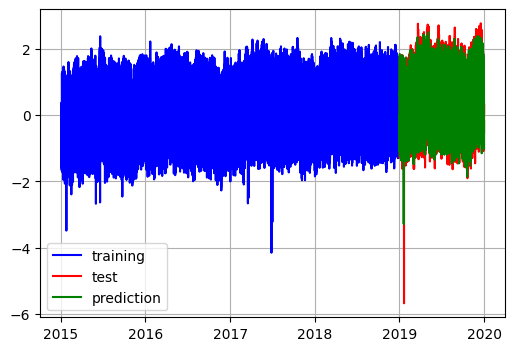

In [34]:
selected_feature = 'nat_demand'
plt.plot(df_train.index, df_train[selected_feature], c='blue', label='training')
plt.plot(df_sliding.index, df_test[selected_feature], c='red', label='test')
plt.plot(df_sliding.index, df_sliding[selected_feature] , c='green', label='prediction')
plt.legend()

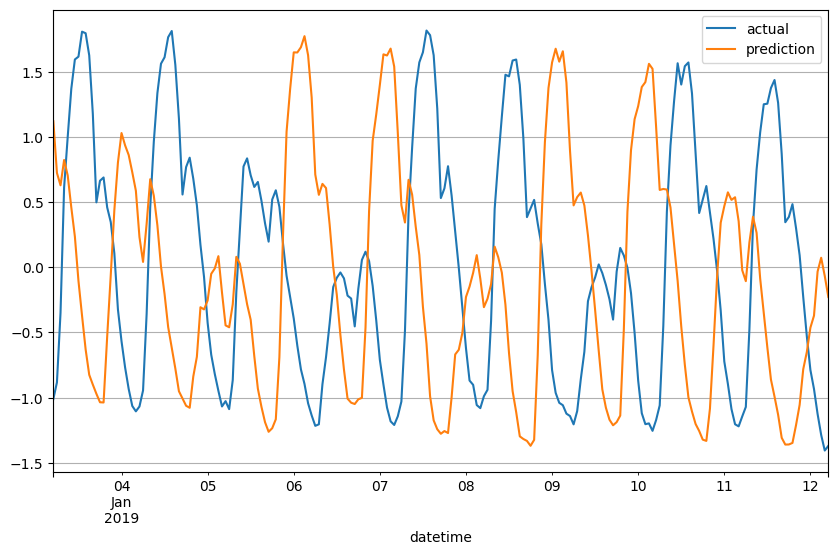

In [35]:
plt.figure(figsize=(10, 6))
df_test.loc['2019-01-03 05:00:00':'2019-01-12 05:00:00', 'nat_demand'].plot(label='actual')
df_sliding.loc['2019-01-03 05:00:00':'2019-01-12 05:00:00', 'nat_demand'].plot(label='prediction')
plt.legend()

# Save Model

In [36]:
os.makedirs('./saved_models', exist_ok=True)

torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'hyperparameters': hyperparameters,
    },
    './saved_models/GPTTimeSeries.pt'
)

### Later: Push **df_sliding** to a database

# Generative Forecast

In [37]:
@torch.no_grad()
def generative_forecast(model, data, num_steps, lag_window_size):
    model.eval()
    
    predictions = []
    time_indexes = []

    _device = next(model.parameters()).device
    
    # covnert to tensor
    # data.shape: (lags, features)
    lags = torch.tensor(data[-lag_window_size:, :], dtype=torch.float32, device=_device)
    
    # artificially add batch dimension
    # (we are not using the dataloader here!)
    # data.shape: (1, lags, features)
    lags = lags.unsqueeze(0)

    # Datetime indexes 
    timestamps = df_full.index
    # Delta time: calculate the time difference between two samples 
    delta_time = timestamps[1] - timestamps[0]
    # Get last timestamp
    current_timestamp = timestamps[-1]
    
    # single step
    for idx in range(num_steps):

        # get the last lag steps
        lags = lags[:, -lag_window_size:, :]
        #print(lags)
        
        forecast_pred = model(lags)
        
        # (batch, forecast, output_features_size)-> (1, 1, output_features_size)
        predictions.append(forecast_pred[0][0].cpu().numpy())

        # update current timestamp
        current_timestamp = current_timestamp + delta_time
        time_indexes.append(current_timestamp)

        # append last forecast to the end
        lags = torch.cat((lags, forecast_pred.detach()), dim=1)

    return predictions, time_indexes

In [38]:
pred_generative, time_indexes_generative = generative_forecast(model, df_full.values, 70, hyperparameters['lags'])

pred_generative_array = np.array(pred_generative)

generative_results_dict = {}

# loop ove features
for feature_id, feature_key in enumerate(df_full.columns):
    generative_results_dict[feature_key] = pred_generative_array[:, feature_id]
        
df_generative = pd.DataFrame(data=generative_results_dict, index=time_indexes_generative)

<Axes: >

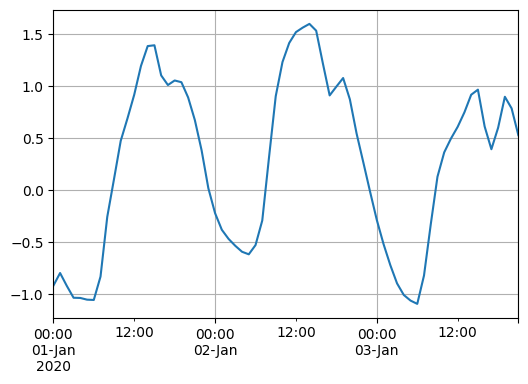

In [39]:
df_generative[selected_feature].plot()